In [94]:
import numpy as np
import json
from utilities import *
from OFDMparam import *
from CFOcorr import *
from getModFeat import *
import random
import os
from glob import glob
from collections import defaultdict

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
pi = math.pi


In [119]:
SNRVec = np.arange(5, 41, 5, dtype=int)

wlanHTInputSym = 40
wlanHEInputSym = 10

f = open('./inputJson/test.json')
dataPath = json.load(f)['data_path']

f = open('./inputJson/class/test_class.json')
classJson = json.load(f)
protocolList = np.array(classJson['protocolList'])
CPOptList = np.array(classJson['CPOptList'], dtype=object)
CPLenList = np.array(classJson['CPLenList'], dtype=object)
modList = np.array(classJson['modList'], dtype=object)

dataDict = {file:[] for file in protocolList}
for i, protocol in enumerate(protocolList):
    dataDict[protocol] = {file:[] for file in CPOptList[i]}
    for CPOpt in CPOptList[i]:
        dataDict[protocol][CPOpt] = {file:[] for file in modList[i]}
        for mod in modList[i]:
            dataDict[protocol][CPOpt][mod] = {file:[] for file in SNRVec}
            for SNR in SNRVec:
                dataDict[protocol][CPOpt][mod][SNR] = defaultdict(list)
# print(dataDict)

In [123]:
for subFolder in os.walk(dataPath):
    dirFilenameList = glob(subFolder[0] + '/*.32cf')
    for fileIndex, dirFileName in enumerate(dirFilenameList):
        fileName = dirFileName.split("/")[-1][:-5]
        fileProtocol = (dirFileName.split("/")[-1][:-5]).split("_")[0]
        fileCPOpt = (dirFileName.split("/")[-1][:-5]).split("_")[1]
        fileMod = int((dirFileName.split("/")[-1][:-5]).split("_")[2])
        fileSNR = int((dirFileName.split("/")[-1][:-5]).split("_")[4])
        
        fileProtocolIndex = int(np.where(protocolList == fileProtocol)[0])
        fileModIndex = int(np.where(np.array(modList[fileProtocolIndex]) == fileMod)[0])
        
        print(type(fileMod), fileSNR)
        # print(fileProtocol, fileProtocolIndex, fileModIndex)
        dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['label'].append(fileModIndex)

        load_out = np.fromfile(dirFileName, dtype=np.float32)
        data = load_out[np.arange(0, load_out.shape[0], 2)] +\
            1j * load_out[np.arange(1, load_out.shape[0], 2)]

SNRVec = np.arange(5, 41, 5, dtype=int)

wlanHTInputSym = 40
wlanHEInputSym = 10

f = open('./inputJson/test.json')
dataPath = json.load(f)['data_path']

f = open('./inputJson/class/test_class.json')
classJson = json.load(f)
protocolList = np.array(classJson['protocolList'])
CPOptList = np.array(classJson['CPOptList'], dtype=object)
CPLenList = np.array(classJson['CPLenList'], dtype=object)
modList = np.array(classJson['modList'], dtype=object)

dataDict = {file:[] for file in protocolList}
for i, protocol in enumerate(protocolList):
    dataDict[protocol] = {file:[] for file in CPOptList[i]}
    for CPOpt in CPOptList[i]:
        dataDict[protocol][CPOpt] = {file:[] for file in modList[i]}
        for mod in modList[i]:
            dataDict[protocol][CPOpt][mod] = {file:[] for file in SNRVec}
            for SNR in SNRVec:
                dataDict[protocol][CPOpt][mod][SNR] = defaultdict(list)
# print(dataDict)

<class 'int'> 20


IndexError: list index out of range

In [11]:
SNRVec = np.arange(40, 41, 2, dtype=int)
FFTsize = 4096
tauVec = np.array([64, 256, 512, 1024, 2048])
CPLenList = [[16, 8], [64, 32, 16], [128, 36], [72], [144]]
CPOptList = np.array([np.array(['Extended', 'Normal']),\
    np.array(['Extended', 'Medium', 'Normal']),\
    np.array(['Extended', 'Normal']),\
    np.array(['Normal']), np.array(['Normal'])], dtype=object)
protocolList = np.array(['wlanHT', 'wlanHE', 'NRDLa', 'NRDLb', 'NRDLc'])

In [11]:
load_out = np.fromfile('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.32cf',\
    dtype=np.float32)
f = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.metadata')
loadMetadata = json.load(f)

data = load_out[np.arange(0, load_out.shape[0], 2)] +\
                    1j * load_out[np.arange(1, load_out.shape[0], 2)]

startIndex:  3515
Truth:  5  Est:  5
7860.295668733161
7732.624599634129
(4485,) (56, 20)


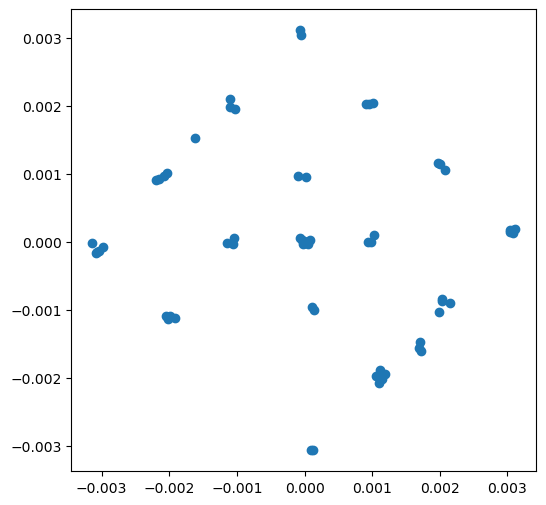

In [14]:
preambLen = 720
nSym = 20
removeNull = True
angleMod = False

startIndex = random.randint(preambLen, data.shape[0] - 2560)
print('startIndex: ', startIndex)
inputIQ = data[startIndex:]
# print(inputIQ.shape[0])
nSubC = 64
lenCP = 16
samplingRate = 20e6
firstIndexSymTruth = findFirstIndex(inputIQ, nSubC, lenCP)
firstIndexSymEst = (-startIndex+preambLen) % (nSubC+lenCP)
print('Truth: ', firstIndexSymTruth, ' Est: ', firstIndexSymEst)

CFOtruth = getCFOtruth(loadMetadata)
print(CFOtruth)
CFOest = estCFO(inputIQ, nSubC, lenCP, firstIndexSymEst, samplingRate)
print(CFOest)

inputIQ_CFO = corrCFO(inputIQ, nSubC, lenCP, firstIndexSymEst, samplingRate, 2)
a = np.fft.fft(inputIQ_CFO[firstIndexSymEst+lenCP:firstIndexSymEst+lenCP+nSubC])
plt.figure(figsize=(6,6))
plt.scatter(np.real(a), np.imag(a))

feat = getModFeat(inputIQ_CFO, nSubC, lenCP, firstIndexSymEst, nSym, removeNull, angleMod)
print(inputIQ_CFO.shape, feat.shape)
# plt.figure(figsize=(6,6))
# plt.scatter(np.real(feat), np.imag(feat))

# xylim = 0.0012
# plt.xlim((0, xylim))
# plt.ylim((0, xylim*0.6))

{2: [], 4: [], 16: [], 64: []}


In [1]:
train_l = list()
test_l = list()
for modul in modulList:
    for SNR in EsNo_l:
        dataset_modul = IQDataset(data_d[modul][SNR],cuda_id=cudaID)

        train_data_num = int(np.ceil(0.8*len(data_d[modul][SNR]['label'])))
        total_data_num = len(data_d[modul][SNR]['label'])
        # if data_type == 'RFMLS':
        #     if modul == 'BPSK':
        #         train_data_num = int(np.ceil(train_data_num / 400))
        #         total_data_num = int(np.ceil(total_data_num / 400))
        #     if modul == 'QPSK':
        #         train_data_num = int(np.ceil(train_data_num / 15))
        #         total_data_num = int(np.ceil(total_data_num / 15))

        train_l.append(torch.utils.data.Subset(dataset_modul,range(train_data_num)))
        # if EsNo == test_EsNo:
        test_l.append(torch.utils.data.Subset(dataset_modul,range(train_data_num, total_data_num)))
        print(len(train_l[-1]), len(test_l[-1]), len(train_l[-1])+len(test_l[-1]))
        

dataset_train = torch.utils.data.ConcatDataset(train_l) # concatenating dataset lists
dataset_test = torch.utils.data.ConcatDataset(test_l)

loader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=True)

NameError: name 'modul' is not defined

In [5]:
preambleLen = 720
loadedNp = np.load('./result/230326_224855/result.npy', allow_pickle=True)
# print(loadedNp[0, :, 1])
loadedNp[0][:, 4] = (-1 * loadedNp[0][:, 4]) % 72
print(loadedNp[0][:, :])

[['wlanHT_Normal_2_0_20_20_0.4_29' 64 8 ... 8 29008.918157799955 0]
 ['wlanHT_Normal_2_0_35_20_0.4_5' 64 8 ... 7 -43802.55759445441 0]
 ['wlanHT_Normal_2_0_20_20_0.4_7' 64 8 ... 63 -51177.62719227465 0]
 ...
 ['wlanHT_Normal_2_0_40_20_0.4_30' 64 8 ... 4 57914.982138170875 0]
 ['wlanHT_Normal_2_0_20_20_0.4_19' 64 8 ... 8 57332.62341307366 0]
 ['wlanHT_Normal_2_0_35_20_0.4_44' 64 8 ... 47 22296.722289942787 0]]
